### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

--2023-10-12 12:31:01--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’

100%[======================================>] 977,501     --.-K/s   in 0.006s  

2023-10-12 12:31:01 (160 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv’ saved [977501/977501]



In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#Preparation
df.columns = df.columns.str.lower().str.replace(' ','_')
categorical_columns=df.columns[df.dtypes == 'object']
for c in categorical_columns:
    df[c]=df[c].str.lower().str.replace(' ','_')
tc=pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges=pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges=df.totalcharges.fillna(0)
df[tc.isnull()][['customerid','totalcharges'] ]

,customerid,totalcharges
488,4472-lvygi,0.0
753,3115-czmzd,0.0
936,5709-lvoeq,0.0
1082,4367-nuyao,0.0
1340,1371-dwpaz,0.0
3331,7644-omvmy,0.0
3826,3213-vvolg,0.0
4380,2520-sgtta,0.0
5218,2923-arzlg,0.0
6670,4075-wkniu,0.0


In [6]:
df.churn = (df.churn == 'yes').astype(int)
from sklearn.model_selection import train_test_split
#Getting the 'full_train' and the 'test'
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
#Getting the 'train' and the 'val'
df_train, df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = df.select_dtypes(include=['object']).columns
categorical=list(categorical)
categorical.remove('customerid')

In [8]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train[categorical+numerical].to_dict(orient='records')
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
dicts_full_train = df_full_train[categorical+numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
y_full_train = df_full_train.churn.values

In [11]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
dicts_test = df_test[categorical+numerical].to_dict(orient='records')

In [13]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.50)
(churn_decision == y_val).mean()

0.8055358410220014

## 4.2 Accuracy

In [14]:
thresholds = np.linspace(0, 1, 21)
highest_score = 0
best_t = 0
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    if highest_score < (churn_decision == y_val).mean():
        highest_score = (churn_decision == y_val).mean()
        best_t = t
    scores.append((churn_decision == y_val).mean())

print(highest_score, best_t)

0.8105039034776437 0.55


## 4.3 Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
print(tp, tn)

218 917


In [18]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
print(fp, fn)

106 168


In [19]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

In [20]:
confusion_matrix

array([[917, 106],
       [168, 218]])

In [21]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [22]:
#Precision = True positive / All positive
p = tp  / (tp+fp)
p
#We've mistakenly "churned" %33.

0.6728395061728395

In [23]:
#Recall = True positive / All prediction
r = tp / (tp+fn)
r
#We've failed to identify 44% of people.
#Accuracy might be misleading.

0.5647668393782384

## 4.5 ROC Curves
### TPR and FPR

In [24]:
#TPR = True Positive Rate
#FPR = False Positive Rate
tpr = tp / (tp + fn)
tpr

0.5647668393782384

In [25]:
fpr = fp / (fp + tn)
fpr

0.10361681329423265

In [26]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [27]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,907,1,116
2,0.02,384,816,2,207
3,0.03,382,757,4,266
4,0.04,382,713,4,310
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [28]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,368,538,18,485
20,0.2,337,361,49,662
30,0.3,299,248,87,775
40,0.4,260,178,126,845
50,0.5,218,106,168,917
60,0.6,161,53,225,970
70,0.7,86,17,300,1006
80,0.8,5,0,381,1023
90,0.9,0,0,386,1023


In [29]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

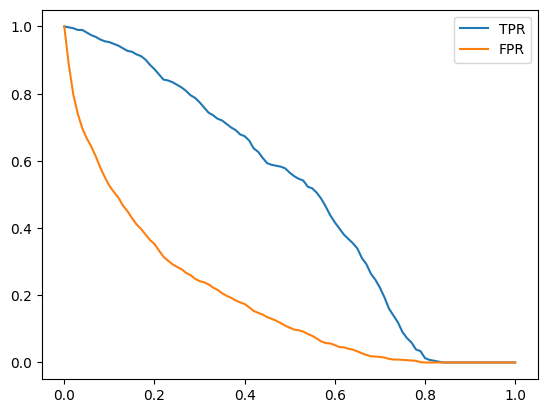

In [30]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

### Random model

In [31]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [32]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [33]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append ((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [34]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

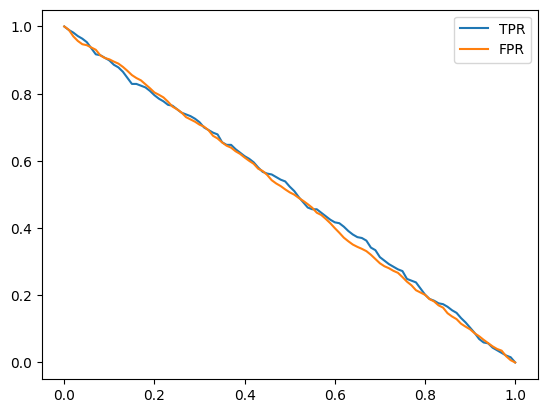

In [35]:
df_rand[::10]

plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend()

### Ideal model

In [36]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [37]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [39]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [40]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

### Putting everything together

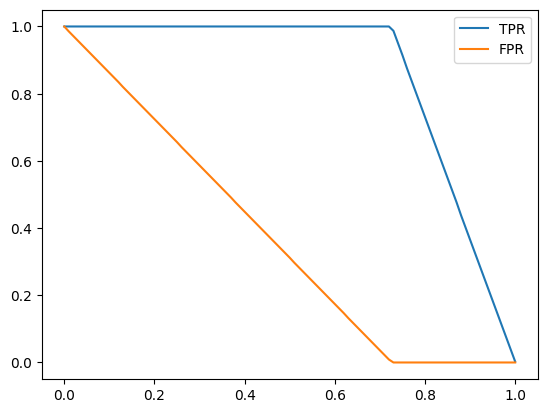

In [41]:

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend()

### Putting everything together

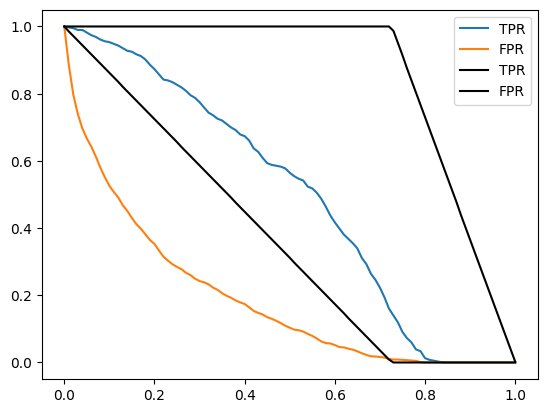

In [42]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')

#plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR', color='black')

plt.legend()

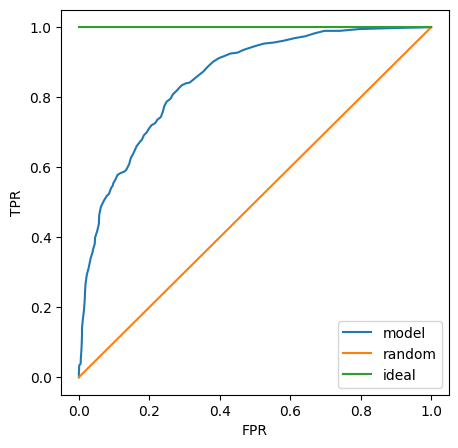

In [43]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot([0,1], [1,1], label='ideal')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

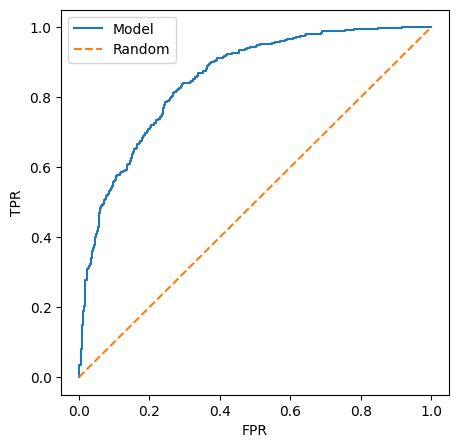

In [46]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle = '--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [47]:
from sklearn.metrics import auc

In [48]:
auc(fpr, tpr)

0.8516681101504768

In [49]:
auc(df_scores.fpr, df_scores.tpr)

0.8514629835037656

In [50]:
from sklearn.metrics import roc_auc_score

In [51]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8516681101504768

In [52]:
roc_auc_score(y_val, y_pred)

0.8516681101504768

## 4.7 Cross Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spred within predictions

In [53]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [54]:
dv, model = train(df_train, y_train)

TypeError: train() missing 1 required positional argument: 'C'

In [55]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [56]:
y_pred = predict(df_val, dv, model)

In [57]:
from sklearn.model_selection import KFold

In [58]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [59]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [60]:
len(train_idx), len(val_idx)

(5070, 564)

In [61]:
len(df_full_train)

5634

In [62]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [63]:
!pip install tqdm

In [64]:
from tqdm.auto import tqdm

In [65]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.839 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.008
C=1 0.841 +- 0.007
C=5 0.841 +- 0.008
C=10 0.840 +- 0.008


In [66]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8581377902000933